In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import sys
sys.path.append('/content/drive/My Drive/CS7643_GroupProject')

In [40]:
import pandas as pd
import numpy as np
import csv
import random
from PIL import Image
from collections import defaultdict
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

from model.CustomCNN import CustomCNN
#from model.EfficientNetwithAttention import EfficientNetWithAttention

%matplotlib inline

#Preprocessing of the fer2013 dataset

Code modified from https://www.kaggle.com/code/vaibhavgovindwar/fer-cnn-lenet-5, https://www.kaggle.com/code/vkoriukina/fer2018-emotion-recognition-pytorch-resnet-18

In [41]:
df = pd.read_csv('/content/drive/My Drive/CS7643_GroupProject/data/fer2013.csv')

In [42]:
df.shape

(35887, 3)

In [43]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [44]:
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [45]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


# Seperate Train, Validation, Test Data

In [46]:
train_df = df[df['Usage']=='Training']
val_df   = df[df['Usage']=='PublicTest']
test_df  = df[df['Usage']=='PrivateTest']
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(train_df.shape, val_df.shape, test_df.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


# Create a custom dataset class
Convert pixel strings from csv file to image and label in tensor form

In [47]:
class FER2013Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): The dataset loaded using pandas DataFrame.
            transform (callable, optional): Optional transformations to apply to the images.
        """
        self.data = data
        self.transform = transform
        self.labels = data['emotion'].values
        self.pixels = data['pixels'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the pixel string to a numpy array, normalize the pixel by dividing by 255 and reshape to 48x48
        image = (np.array(self.pixels[idx].split(), dtype=np.float32)/255).reshape(48, 48)
        label = int(self.labels[idx])

        # Apply transformations if provided
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)

        # Convert image and label to tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

#Define Transformation and Initialize Datasets

In [48]:
# Train transformation without data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

# Data augmentation of horizontal mirroring, ±10 degree rotations, ±10% image zooms, and ±10% horizontal/vertical shifting,
# Pixel values normalized to [-1, 1]
train_transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1), # ±10% horizontal and vertical shifting
        scale=(0.9, 1.1) # ±10% zoom (scale between 90% and 110%)
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = FER2013Dataset(train_df, train_transform)
train_dataset_with_augmentation = FER2013Dataset(train_df, train_transform_with_augmentation)
val_dataset = FER2013Dataset(val_df, test_transform)
test_dataset = FER2013Dataset(test_df, test_transform)

# Create DataLoader

In [49]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
train_augmented_dataloader = DataLoader(train_dataset_with_augmentation, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model = CustomCNN

In [51]:
model = CustomCNN()
model = model.to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, o

# Define Optimizer, Loss Function and Hyperparameters

In [52]:
EPOCHS = 100
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Define Train, Validation and Accuracy Function

In [53]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for images, labels in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [54]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train using augmented data

In [56]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_augmented_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

<ipython-input-47-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.7619,          Train acc: 0.2711,          Val loss: 1.5536,          Val acc: 0.3544          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.5532,          Train acc: 0.3890,          Val loss: 1.4107,          Val acc: 0.4615          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.4497,          Train acc: 0.4435,          Val loss: 1.3236,          Val acc: 0.4877          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.3944,          Train acc: 0.4689,          Val loss: 1.2934,          Val acc: 0.4868          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.3499,          Train acc: 0.4868,          Val loss: 1.2486,          Val acc: 0.5242          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.3143,          Train acc: 0.4990,          Val loss: 1.1880,          Val acc: 0.5418          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.2906,          Train acc: 0.5085,          Val loss: 1.1987,          Val acc: 0.5383          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.2685,          Train acc: 0.5183,          Val loss: 1.1992,          Val acc: 0.5448          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.2501,          Train acc: 0.5303,          Val loss: 1.2043,          Val acc: 0.5464          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.2319,          Train acc: 0.5366,          Val loss: 1.1204,          Val acc: 0.5684          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.2098,          Train acc: 0.5463,          Val loss: 1.1331,          Val acc: 0.5720          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 1.2011,          Train acc: 0.5498,          Val loss: 1.1024,          Val acc: 0.5831          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 1.1955,          Train acc: 0.5534,          Val loss: 1.0862,          Val acc: 0.5816          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 1.1727,          Train acc: 0.5600,          Val loss: 1.0858,          Val acc: 0.5835          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 1.1682,          Train acc: 0.5656,          Val loss: 1.0922,          Val acc: 0.5838          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 16,          Train loss: 1.1507,          Train acc: 0.5705,          Val loss: 1.1003,          Val acc: 0.5824          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 17,          Train loss: 1.1503,          Train acc: 0.5736,          Val loss: 1.0759,          Val acc: 0.5808          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 18,          Train loss: 1.1350,          Train acc: 0.5740,          Val loss: 1.0780,          Val acc: 0.5971          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 19,          Train loss: 1.1246,          Train acc: 0.5827,          Val loss: 1.0585,          Val acc: 0.5978          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 20,          Train loss: 1.1178,          Train acc: 0.5841,          Val loss: 1.0243,          Val acc: 0.6122          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 21,          Train loss: 1.1130,          Train acc: 0.5845,          Val loss: 1.0955,          Val acc: 0.5904          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 22,          Train loss: 1.1040,          Train acc: 0.5898,          Val loss: 1.0257,          Val acc: 0.6101          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 23,          Train loss: 1.0977,          Train acc: 0.5920,          Val loss: 1.0209,          Val acc: 0.6232          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 24,          Train loss: 1.0905,          Train acc: 0.5924,          Val loss: 1.0617,          Val acc: 0.5972          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 25,          Train loss: 1.0839,          Train acc: 0.5996,          Val loss: 1.0477,          Val acc: 0.6032          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 26,          Train loss: 1.0760,          Train acc: 0.6005,          Val loss: 1.0256,          Val acc: 0.6153          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 27,          Train loss: 1.0721,          Train acc: 0.6007,          Val loss: 1.0166,          Val acc: 0.6142          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 28,          Train loss: 1.0674,          Train acc: 0.6046,          Val loss: 1.0073,          Val acc: 0.6282          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 29,          Train loss: 1.0602,          Train acc: 0.6077,          Val loss: 0.9916,          Val acc: 0.6224          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 30,          Train loss: 1.0566,          Train acc: 0.6106,          Val loss: 1.0304,          Val acc: 0.6175          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 31,          Train loss: 1.0439,          Train acc: 0.6118,          Val loss: 1.0762,          Val acc: 0.5999          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 32,          Train loss: 1.0447,          Train acc: 0.6137,          Val loss: 1.0370,          Val acc: 0.6109          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 33,          Train loss: 1.0420,          Train acc: 0.6143,          Val loss: 1.0032,          Val acc: 0.6238          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 34,          Train loss: 1.0323,          Train acc: 0.6156,          Val loss: 0.9734,          Val acc: 0.6270          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 35,          Train loss: 1.0312,          Train acc: 0.6174,          Val loss: 0.9925,          Val acc: 0.6325          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 36,          Train loss: 1.0350,          Train acc: 0.6171,          Val loss: 1.0207,          Val acc: 0.6257          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 37,          Train loss: 1.0350,          Train acc: 0.6171,          Val loss: 0.9957,          Val acc: 0.6271          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 38,          Train loss: 1.0242,          Train acc: 0.6212,          Val loss: 0.9755,          Val acc: 0.6314          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 39,          Train loss: 1.0222,          Train acc: 0.6257,          Val loss: 0.9763,          Val acc: 0.6306          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 40,          Train loss: 1.0170,          Train acc: 0.6247,          Val loss: 0.9704,          Val acc: 0.6433          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 41,          Train loss: 1.0176,          Train acc: 0.6251,          Val loss: 0.9901,          Val acc: 0.6257          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 42,          Train loss: 1.0079,          Train acc: 0.6255,          Val loss: 0.9677,          Val acc: 0.6391          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 43,          Train loss: 1.0053,          Train acc: 0.6275,          Val loss: 0.9685,          Val acc: 0.6468          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 44,          Train loss: 1.0082,          Train acc: 0.6244,          Val loss: 0.9870,          Val acc: 0.6331          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 45,          Train loss: 0.9996,          Train acc: 0.6313,          Val loss: 0.9656,          Val acc: 0.6453          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 46,          Train loss: 1.0004,          Train acc: 0.6316,          Val loss: 0.9521,          Val acc: 0.6435          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 47,          Train loss: 0.9941,          Train acc: 0.6335,          Val loss: 0.9938,          Val acc: 0.6314          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 48,          Train loss: 0.9905,          Train acc: 0.6332,          Val loss: 0.9455,          Val acc: 0.6528          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 49,          Train loss: 0.9944,          Train acc: 0.6360,          Val loss: 0.9636,          Val acc: 0.6391          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 50,          Train loss: 0.9845,          Train acc: 0.6375,          Val loss: 0.9906,          Val acc: 0.6304          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 51,          Train loss: 0.9862,          Train acc: 0.6372,          Val loss: 0.9919,          Val acc: 0.6216          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 52,          Train loss: 0.9785,          Train acc: 0.6392,          Val loss: 0.9724,          Val acc: 0.6527          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 53,          Train loss: 0.9818,          Train acc: 0.6385,          Val loss: 0.9682,          Val acc: 0.6413          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 54,          Train loss: 0.9796,          Train acc: 0.6399,          Val loss: 0.9458,          Val acc: 0.6446          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 55,          Train loss: 0.9714,          Train acc: 0.6406,          Val loss: 0.9570,          Val acc: 0.6424          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 56,          Train loss: 0.9719,          Train acc: 0.6391,          Val loss: 0.9534,          Val acc: 0.6476          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 57,          Train loss: 0.9699,          Train acc: 0.6404,          Val loss: 0.9467,          Val acc: 0.6528          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 58,          Train loss: 0.9732,          Train acc: 0.6436,          Val loss: 0.9590,          Val acc: 0.6363          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 59,          Train loss: 0.9682,          Train acc: 0.6427,          Val loss: 0.9491,          Val acc: 0.6479          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 60,          Train loss: 0.9117,          Train acc: 0.6643,          Val loss: 0.9194,          Val acc: 0.6616          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 61,          Train loss: 0.8851,          Train acc: 0.6740,          Val loss: 0.9165,          Val acc: 0.6671          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 62,          Train loss: 0.8689,          Train acc: 0.6778,          Val loss: 0.9157,          Val acc: 0.6703          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 63,          Train loss: 0.8642,          Train acc: 0.6813,          Val loss: 0.9193,          Val acc: 0.6665          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 64,          Train loss: 0.8587,          Train acc: 0.6846,          Val loss: 0.9189,          Val acc: 0.6654          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 65,          Train loss: 0.8502,          Train acc: 0.6886,          Val loss: 0.9174,          Val acc: 0.6649          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 66,          Train loss: 0.8444,          Train acc: 0.6886,          Val loss: 0.9220,          Val acc: 0.6690          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 67,          Train loss: 0.8425,          Train acc: 0.6930,          Val loss: 0.9238,          Val acc: 0.6698          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 68,          Train loss: 0.8384,          Train acc: 0.6891,          Val loss: 0.9133,          Val acc: 0.6692          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 69,          Train loss: 0.8329,          Train acc: 0.6939,          Val loss: 0.9232,          Val acc: 0.6706          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 70,          Train loss: 0.8341,          Train acc: 0.6908,          Val loss: 0.9161,          Val acc: 0.6723          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 71,          Train loss: 0.8270,          Train acc: 0.6924,          Val loss: 0.9153,          Val acc: 0.6745          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 72,          Train loss: 0.8160,          Train acc: 0.7008,          Val loss: 0.9242,          Val acc: 0.6684          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 73,          Train loss: 0.8198,          Train acc: 0.6994,          Val loss: 0.9278,          Val acc: 0.6674          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 74,          Train loss: 0.8156,          Train acc: 0.7000,          Val loss: 0.9167,          Val acc: 0.6690          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 75,          Train loss: 0.8131,          Train acc: 0.7024,          Val loss: 0.9216,          Val acc: 0.6707          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 76,          Train loss: 0.8125,          Train acc: 0.6986,          Val loss: 0.9125,          Val acc: 0.6706          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 77,          Train loss: 0.8073,          Train acc: 0.7014,          Val loss: 0.9176,          Val acc: 0.6750          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 78,          Train loss: 0.8060,          Train acc: 0.7030,          Val loss: 0.9163,          Val acc: 0.6753          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 79,          Train loss: 0.8061,          Train acc: 0.7033,          Val loss: 0.9197,          Val acc: 0.6712          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 80,          Train loss: 0.7955,          Train acc: 0.7045,          Val loss: 0.9233,          Val acc: 0.6731          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 81,          Train loss: 0.7951,          Train acc: 0.7067,          Val loss: 0.9255,          Val acc: 0.6709          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 82,          Train loss: 0.7925,          Train acc: 0.7078,          Val loss: 0.9230,          Val acc: 0.6728          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 83,          Train loss: 0.7893,          Train acc: 0.7116,          Val loss: 0.9192,          Val acc: 0.6736          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 84,          Train loss: 0.7823,          Train acc: 0.7110,          Val loss: 0.9298,          Val acc: 0.6671          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 85,          Train loss: 0.7886,          Train acc: 0.7082,          Val loss: 0.9267,          Val acc: 0.6747          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 86,          Train loss: 0.7836,          Train acc: 0.7110,          Val loss: 0.9327,          Val acc: 0.6701          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 87,          Train loss: 0.7817,          Train acc: 0.7138,          Val loss: 0.9173,          Val acc: 0.6706          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 88,          Train loss: 0.7742,          Train acc: 0.7141,          Val loss: 0.9219,          Val acc: 0.6720          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 89,          Train loss: 0.7764,          Train acc: 0.7150,          Val loss: 0.9218,          Val acc: 0.6714          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 90,          Train loss: 0.7724,          Train acc: 0.7147,          Val loss: 0.9213,          Val acc: 0.6701          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 91,          Train loss: 0.7749,          Train acc: 0.7163,          Val loss: 0.9233,          Val acc: 0.6712          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 92,          Train loss: 0.7789,          Train acc: 0.7165,          Val loss: 0.9240,          Val acc: 0.6717          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 93,          Train loss: 0.7699,          Train acc: 0.7190,          Val loss: 0.9238,          Val acc: 0.6736          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 94,          Train loss: 0.7758,          Train acc: 0.7118,          Val loss: 0.9244,          Val acc: 0.6709          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 95,          Train loss: 0.7717,          Train acc: 0.7157,          Val loss: 0.9234,          Val acc: 0.6758          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 96,          Train loss: 0.7685,          Train acc: 0.7167,          Val loss: 0.9247,          Val acc: 0.6731          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 97,          Train loss: 0.7735,          Train acc: 0.7166,          Val loss: 0.9221,          Val acc: 0.6742          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 98,          Train loss: 0.7710,          Train acc: 0.7160,          Val loss: 0.9221,          Val acc: 0.6731          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 99,          Train loss: 0.7667,          Train acc: 0.7159,          Val loss: 0.9234,          Val acc: 0.6725          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 100,          Train loss: 0.7759,          Train acc: 0.7140,          Val loss: 0.9243,          Val acc: 0.6731          
DONE TRAINING


# Loss and Accuracy Plot For Train and Validation Data

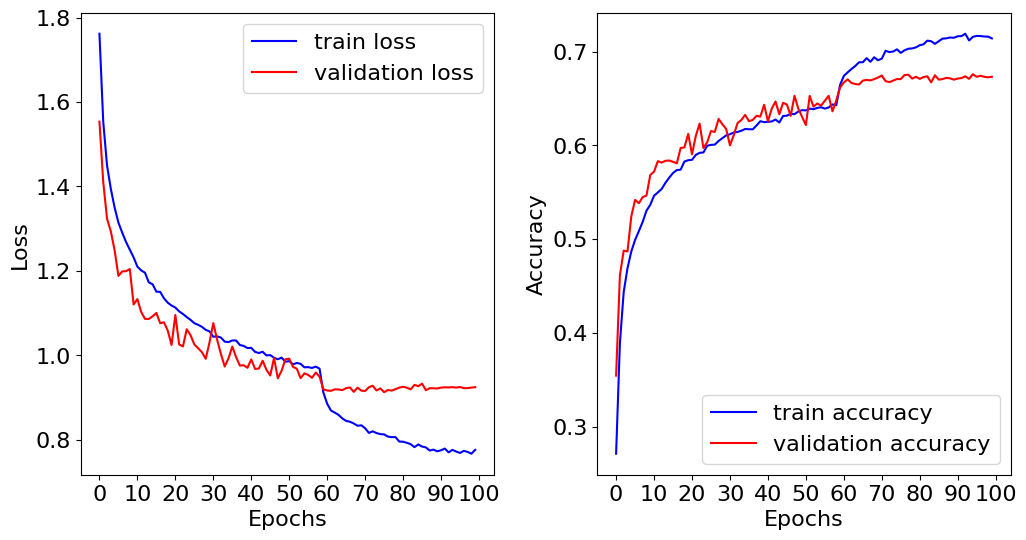

In [57]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validation accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

# Define Test Function

In [58]:
classes = list(emotion_labels.values())
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

<ipython-input-47-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


# Test Accuracy for Each Class

In [59]:
for classname, correct_count in dict(sorted(correct_pred.items())).items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total test accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.5927
Accuracy for class: Disgust is 0.6727
Accuracy for class: Fear  is 0.3977
Accuracy for class: Happy is 0.9124
Accuracy for class: Neutral is 0.7444
Accuracy for class: Sad   is 0.5707
Accuracy for class: Surprise is 0.8125
Total test accuracy: 0.6918


# Confusion Matrix

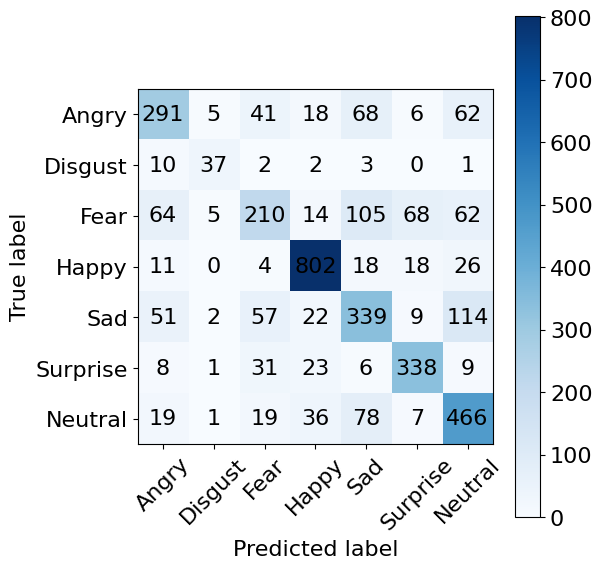

In [60]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix)
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions)
plt.show()